## 1. 定义算法

DQN 经验回放的算法中的均匀采样算法，可能会忘记一些重要的、以后使用的经验数据。针对这样的问题，PER_DQN 提出了优先级经验回放（prioritized experience reolay）的技术来解决，这种方法应用到 DQN 获得了更好的效果。PER_DQN 成功的原因有：
1. 提出了sum tree这样复杂度为O(logn)的高效数据结构
2. 正确估计了 weighted importance sampling

注意, 本Notebook的Buffer实现用的是简化的方式，想参考原论文sum tree的实现参考其他Notebook即可

### 定义模型

同 DQN 。

In [94]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
        """
        super(Model, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 定义经验回放

在实现上PER有两种方式，一个是简版PER，另一个就是接近原论文的SumTree PER，两者主要有以下不同：

* 数据结构: 前者使用数组保存优先级，后者则用二叉树(SumTree)保存
* 采样复杂度: 采样时前者是直接用概率分布随机，复杂度是 O(N)（慢）, 后者用树查找，复杂度是 O(log N)（快）
* 更新优先级复杂度: 前者直接更新数组，O(1)（快）, 后者更新树上的节点，O(log N)（稍慢，但可以承受）
* 内存开销: 小（1个数组）, 后者略大（1棵树 + 1个数据数组）
* 适合场景： 小 buffer（比如几千条数据以内）, 大 buffer（比如一万到几十万条数据）

我们仅在此Notebook上实现简版的PER, 其余默认使用SumTree PER


In [ ]:
import numpy as np

class ReplayBuffer:
    def __init__(self, cfg):
        self.capacity = cfg.buffer_size
        self.alpha = cfg.per_alpha
        self.beta = cfg.per_beta
        self.beta_increment_per_sampling = cfg.per_beta_increment_per_sampling
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((self.capacity,), dtype=np.float32)

    def push(self, transition):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        self.beta = min(1.0, self.beta + self.beta_increment_per_sampling)
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:len(self.buffer)]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        batch = list(zip(*samples))
        return tuple(map(lambda x: np.array(x), batch)), indices, weights

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

### 定义策略

同 DQN 。

In [ ]:
import torch
import torch.optim as optim
import math
import numpy as np
import random


class Policy:
    def __init__(self, cfg):
        self.action_dim = cfg.action_dim  # 动作空间的维度
        self.device = torch.device(cfg.device) # CPU或GPU 
        self.gamma = cfg.gamma  # 奖励的折扣因子
        ## e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg.epsilon_start
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.target_update = cfg.target_update
        # 当前网络和目标网络
        self.model = Model(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.hidden_dim).to(self.device)
        self.target_model = Model(cfg.state_dim, cfg.action_dim, hidden_dim = cfg.hidden_dim).to(self.device)
        # # 复制参数到目标网络
        # for target_param, param in zip(self.target_model.parameters(),self.model.parameters()): 
        #     target_param.data.copy_(param.data)
        self.target_model.load_state_dict(self.model.state_dict()) # 复制参数到目标网络
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.lr) 
        self.memory = ReplayBuffer(cfg) # 经验回放
        self.update_cnt = 0
        
    def sample_action(self, state):
        ''' sample action with e-greedy policy
        '''
        self.sample_count += 1
        # epsilon 指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            action = self.predict_action(state) # 预测动作
        else:
            action = random.randrange(self.action_dim) # 随机动作, 便于前期探索
        return action
    
    @torch.no_grad()
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0) # [1, state_dim]
        q_values = self.model(state)
        action = q_values.max(1)[1].item() 
        return action
    
    def get_policy_params(self):
        ''' 获取当前策略的参数
        '''
        return self.model.state_dict()
    
    def load_policy_params(self, params):
        ''' 加载策略参数
        '''
        self.model.load_state_dict(params)
    
    def update(self):
        if len(self.memory) < self.batch_size: # 不满足一个批量时，不更新策略
            return
        # 采样一个batch
        (states, actions, rewards, next_states, dones), idxs, weights = self.memory.sample(
            self.batch_size)
        states = torch.tensor(np.array(states), device=self.device, dtype=torch.float) # [B, state_dim]]
        actions = torch.tensor(actions, device=self.device, dtype=torch.int64).unsqueeze(1) # [B,1]
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float).unsqueeze(1) # [B,1]
        next_states = torch.tensor(np.array(next_states), device=self.device, dtype=torch.float) # [B, state_dim]]
        dones = torch.tensor(np.float32(dones), device=self.device).unsqueeze(1) # [B,1]
        weights = torch.tensor(weights, device=self.device, dtype=torch.float).unsqueeze(1) # [B,1]

        q_value = self.model(states).gather(dim=1, index=actions) # [B,1]
        next_q_value_max = self.target_model(next_states).max(1)[0].detach().unsqueeze(1) 
        expected_q_value = rewards + self.gamma * next_q_value_max* (1-dones)
        td_errors = abs(q_value - expected_q_value)

        # loss中根据优先度进行了加权
        loss = (td_errors ** 2 * weights).mean()

        priorities = td_errors.squeeze().cpu().detach().numpy() + 1e-5 # 计算TD误差
        # 需要更新样本的优先度
        self.memory.update_priorities(idxs, priorities) 

        # 反向传播
        self.optimizer.zero_grad()  
        loss.backward()
        # 梯度截断，防止梯度爆炸
        for param in self.model.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 
        self.update_cnt += 1
        if self.update_cnt % self.target_update == 0: # 更新 target_model
            self.target_model.load_state_dict(self.model.state_dict()) 


## 设置参数和定义可视化函数

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线, 类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    allow_types = ['int', 'float', 'str', 'bool', 'list', 'dict']
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        if v.__class__.__name__ not in allow_types:
            continue
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

class Config:
    def __init__(self) -> None:
        self.algo_name = 'PER_DQN' # 算法名称
        self.env_id = 'CartPole-v1' # 环境id
        self.mode = 'train'
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.max_epsiode = 200 # 训练的回合数
        self.max_epsiode_test = 20 # 测试的回合数
        self.max_step = 200 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.99 # 折扣因子
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500 # e-greedy策略中epsilon的衰减率
        self.hidden_dim = 256 # 神经网络的隐藏层维度
        self.batch_size = 64 # 批次大小
        self.target_update = 100 # 目标网络的更新频率
        self.lr = 0.0001 # 学习率
        #region buffer相关参数
        self.buffer_size = 100000 # 经验回放池的容量
        self.per_alpha = 0.6 # 优先级的指数 
        self.per_beta = 0.4 # beta的初始值
        self.per_beta_increment_per_sampling = 0.0001 # beta的增量
        #endregion
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda'
        self.reward_threshold = 200 # 奖励阈值，达到该值则认为训练成功
        self.reward_threshold_limit = 10 # 累计一定训练成功次数后停止训练, 这样可以避免训练过长时间

### 定义训练

In [ ]:

import gymnasium as gym

def make_env(cfg: Config):
    ''' 创建环境
    '''
    env = gym.make(cfg.env_id) # 创建环境
    setattr(cfg, "action_space", env.action_space) # 动作空间
    setattr(cfg, "state_dim", env.observation_space.shape[0]) # 状态维度
    setattr(cfg, "action_dim", env.action_space.n) # 动作维度
    return env

def train(cfg: Config, env, policy):
    ''' 训练
    '''
    rewards = []  # 记录所有回合的奖励
    best_policy_params = None  # 最佳策略
    best_ep_reward = float('-inf') # 最佳回合的奖励
    reward_threshold_cnt = 0 # 奖励阈值计数器
    frames = []
    for i_ep in range(cfg.max_epsiode):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_step):
            ep_step += 1
            action = policy.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            policy.memory.push((state, action, reward, next_state, float(truncated or terminated)))   # 保存transition
            state = next_state  # 更新下一个状态
            policy.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if terminated:
                if ep_reward >= best_ep_reward:  # 更新最佳策略
                    best_ep_reward = ep_reward
                    best_policy_params = policy.model.state_dict()
                    print(f"更新最佳策略，回合：{i_ep+1}/{cfg.max_epsiode},  最佳奖励：{best_ep_reward:.2f}")
                if ep_reward >= cfg.reward_threshold:
                    reward_threshold_cnt += 1
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        if reward_threshold_cnt >= cfg.reward_threshold_limit:
            print(f"达到奖励阈值累计{cfg.reward_threshold_limit}次, 训练成功，回合：{i_ep+1}/{cfg.max_epsiode}，奖励：{ep_reward:.2f}")
            break
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.max_epsiode}，奖励：{ep_reward:.2f}, Epislon: {policy.epsilon:.3f}")
    env.close()
    return {'rewards':rewards, 'frames':frames, 'best_policy_params':best_policy_params} # 返回训练结果

### 开始训练

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	      PER_DQN       	   <class 'str'>    
       env_id       	    CartPole-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
    max_epsiode     	        200         	   <class 'int'>    
  max_epsiode_test  	         20         	   <class 'int'>    
      max_step      	        200         	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
    buffer_size     	       100000       	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	        100      

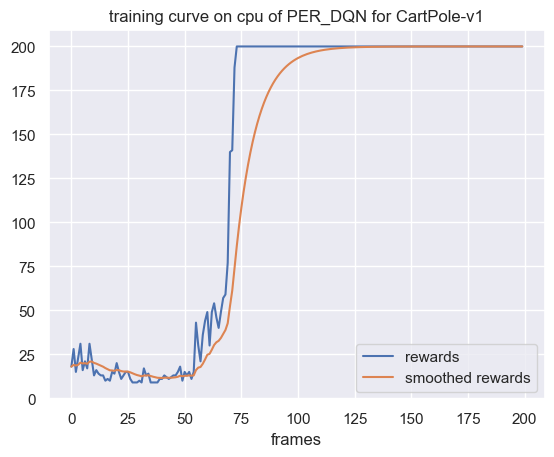

In [99]:
# 获取参数
cfg = Config() 
env = make_env(cfg) # 创建环境
policy = Policy(cfg)
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg,env,policy) # 训练
plot_rewards(cfg, res['frames'], res['rewards'])

## 策略测试

回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：200.00
回合：20/20，奖励：200.00


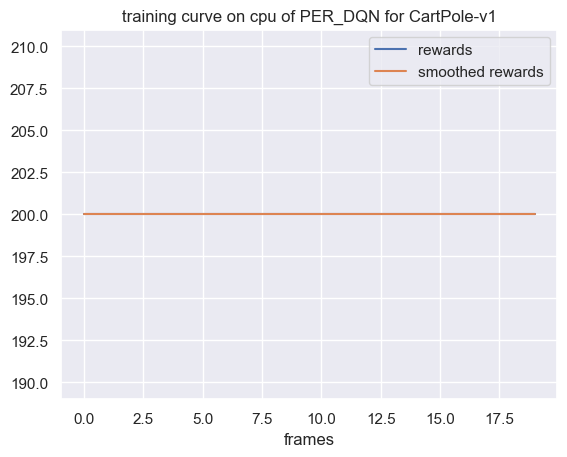

In [100]:
def test(cfg, env, policy: Policy):
    ''' 测试
    '''
    rewards = []  # 记录所有回合的奖励
    frames = []
    for i_ep in range(cfg.max_epsiode_test):
        ep_reward = 0  # 记录一回合内的奖励
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_step):
            action = policy.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        print(f"回合：{i_ep+1}/{cfg.max_epsiode_test}，奖励：{ep_reward:.2f}")
    env.close()
    return {'rewards':rewards, 'frames':frames}
test_env = make_env(cfg)
test_policy = Policy(cfg)
test_policy.load_policy_params(res['best_policy_params']) # 加载训练时的最佳策略参数
test_res = test(cfg, test_env, test_policy)
plot_rewards(cfg, test_res['frames'], test_res['rewards'])